In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import torch
from Common import NeuralNetReLu, NeuralNet

In [2]:
#median_house_value is the target variable that we want to predict
full_df = pd.read_csv(os.path.join("Task3", 'housing.csv'))
full_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
#divide dataset into test and training set
train_df, test_df = train_test_split(full_df,shuffle = True, test_size = 0.25, random_state=17)
train_df=train_df.copy()
test_df=test_df.copy()

In [4]:
full_df.info()
#most columns has no nan values (except total_bedrooms), most features has float format, only 1 feature is categorical - ocean_proximity

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
#Create the list of numerical features names
numerical_features=list(train_df.columns)
numerical_features.remove('ocean_proximity')
numerical_features.remove('median_house_value')
numerical_features

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>, <Axes: >]],
      dtype=object)

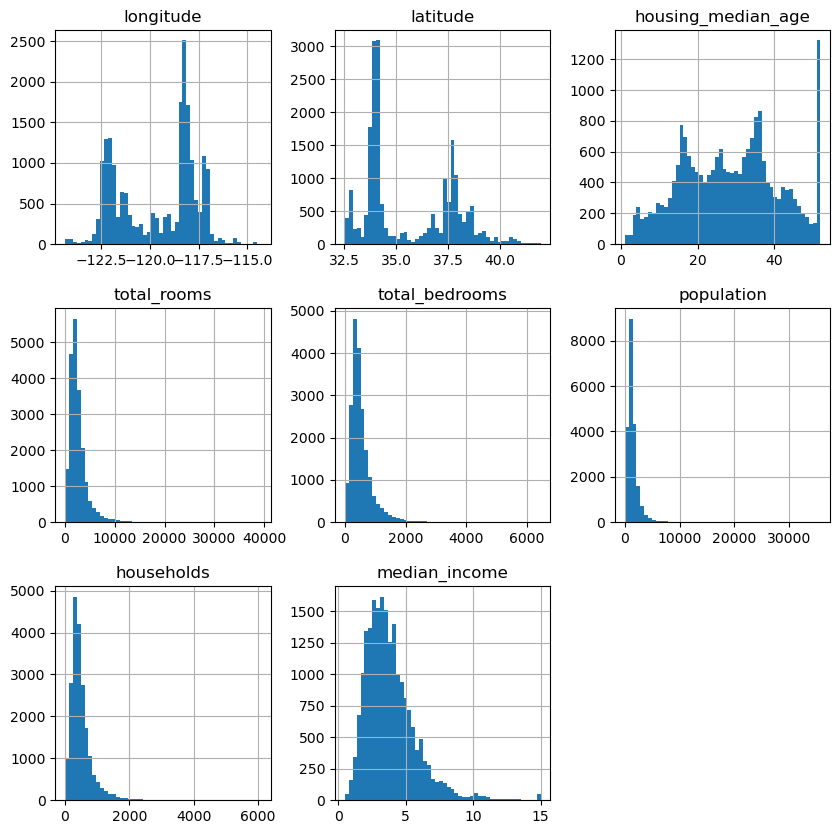

In [6]:
#Distribution of numerical features
full_df[numerical_features].hist(bins=50, figsize=(10, 10))

In [7]:
#Some distributions are skewed. To reduce the skewedness and the effect of outliers on the regression analysis,
#we do a log transformation on the relevant distributions.
skewed_features = ['households','median_income','population', 'total_bedrooms', 'total_rooms', 'median_house_value']
log_numerical_features=[]
for f in skewed_features:
    train_df[f + '_log']=np.log1p(train_df[f])
    test_df[f + '_log']=np.log1p(test_df[f])
    log_numerical_features.append(f + '_log')


array([[<Axes: title={'center': 'households_log'}>,
        <Axes: title={'center': 'median_income_log'}>],
       [<Axes: title={'center': 'population_log'}>,
        <Axes: title={'center': 'total_bedrooms_log'}>],
       [<Axes: title={'center': 'total_rooms_log'}>,
        <Axes: title={'center': 'median_house_value_log'}>]], dtype=object)

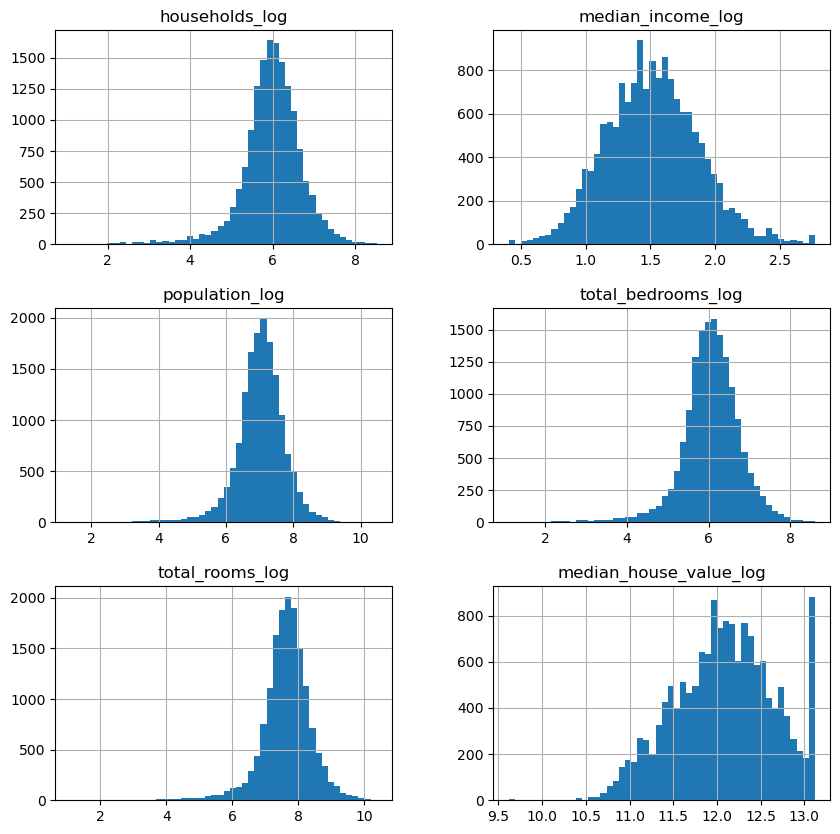

In [8]:
#Analyse distributions of the numerical features after log-transformation
train_df[log_numerical_features].hist(bins=50, figsize=(10, 10))

In [9]:
#Analyse correleation between features and target variable
corr_y = train_df[numerical_features].corr()
corr_y


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
longitude,1.000000,-0.924773,-0.117837,0.052396,0.076960,0.108286,0.061890,-0.015320
latitude,-0.924773,1.000000,0.018670,-0.042183,-0.071737,-0.114588,-0.074982,-0.079439
housing_median_age,-0.117837,0.018670,1.000000,-0.366601,-0.322325,-0.299712,-0.304008,-0.125040
total_rooms,0.052396,-0.042183,-0.366601,1.000000,0.931118,0.857806,0.920838,0.203217
total_bedrooms,0.076960,-0.071737,-0.322325,0.931118,1.000000,0.876404,0.980307,-0.003973
population,0.108286,-0.114588,-0.299712,0.857806,0.876404,1.000000,0.905429,0.009725
households,0.061890,-0.074982,-0.304008,0.920838,0.980307,0.905429,1.000000,0.016076
median_income,-0.015320,-0.079439,-0.125040,0.203217,-0.003973,0.009725,0.016076,1.000000


In [10]:
#To avoid multicolinearity, we drop features that are highly correlated. This helps reducing the risk of overfittig
#and allows our models to generalize
train_df.drop(columns=['total_bedrooms', 'households', 'total_bedrooms_log', 'households_log'])
test_df.drop(columns=['total_bedrooms', 'households', 'total_bedrooms_log', 'households_log'])

,longitude,latitude,housing_median_age,total_rooms,population,median_income,median_house_value,ocean_proximity,median_income_log,population_log,total_rooms_log,median_house_value_log
18403,-121.84,37.24,24.0,7991.0,4017.0,5.4741,238800.0,<1H OCEAN,1.867810,8.298540,8.986196,12.383386
13405,-117.46,34.10,7.0,1759.0,1064.0,1.9583,108800.0,INLAND,1.084615,6.970730,7.473069,11.597276
9539,-120.71,37.39,40.0,680.0,785.0,2.6058,72700.0,INLAND,1.282544,6.666957,6.523562,11.194110
8668,-118.39,33.82,30.0,3433.0,1526.0,4.5817,500001.0,NEAR OCEAN,1.719493,7.331060,8.141481,13.122367
9019,-118.78,34.16,9.0,30405.0,12873.0,8.0137,399200.0,NEAR OCEAN,2.198746,9.462965,10.322395,12.897220
...,...,...,...,...,...,...,...,...,...,...,...,...
17668,-121.88,37.32,45.0,2213.0,1920.0,3.2806,164200.0,<1H OCEAN,1.454093,7.560601,7.702556,12.008847
4569,-118.27,34.07,42.0,1175.0,1593.0,2.3438,213300.0,<1H OCEAN,1.207108,7.374002,7.069874,12.270460
37,-122.28,37.83,52.0,1511.0,901.0,1.4103,103900.0,NEAR BAY,0.879751,6.804615,7.321189,11.551194
13815,-117.22,34.44,5.0,4787.0,1944.0,2.6576,98500.0,INLAND,1.296807,7.573017,8.473868,11.497822


In [11]:
#OneHotEncoding for the feature "ocean_proximity"
ocean_proximity_dummies = pd.get_dummies(pd.concat([train_df['ocean_proximity'],test_df['ocean_proximity']]), drop_first=True)
dummies_names = list(ocean_proximity_dummies.columns)
train_df=pd.concat([train_df,ocean_proximity_dummies[:train_df.shape[0]]], axis=1 )
test_df=pd.concat([test_df,ocean_proximity_dummies[train_df.shape[0]:]], axis=1 )

train_df=train_df.drop(['ocean_proximity'], axis=1)
test_df=test_df.drop(['ocean_proximity'], axis=1)

train_df['INLAND'] = train_df['INLAND'].astype(int)
train_df['ISLAND'] = train_df['ISLAND'].astype(int)
train_df['NEAR BAY'] = train_df['NEAR BAY'].astype(int)
train_df['NEAR OCEAN'] = train_df['NEAR OCEAN'].astype(int)

test_df['INLAND'] = test_df['INLAND'].astype(int)
test_df['ISLAND'] = test_df['ISLAND'].astype(int)
test_df['NEAR BAY'] = test_df['NEAR BAY'].astype(int)
test_df['NEAR OCEAN'] = test_df['NEAR OCEAN'].astype(int)

test_df



,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,households_log,median_income_log,population_log,total_bedrooms_log,total_rooms_log,median_house_value_log,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
18403,-121.84,37.24,24.0,7991.0,1286.0,4017.0,1213.0,5.4741,238800.0,7.101676,1.867810,8.298540,7.160069,8.986196,12.383386,0,0,0,0
13405,-117.46,34.10,7.0,1759.0,473.0,1064.0,328.0,1.9583,108800.0,5.796058,1.084615,6.970730,6.161207,7.473069,11.597276,1,0,0,0
9539,-120.71,37.39,40.0,680.0,160.0,785.0,175.0,2.6058,72700.0,5.170484,1.282544,6.666957,5.081404,6.523562,11.194110,1,0,0,0
8668,-118.39,33.82,30.0,3433.0,918.0,1526.0,828.0,4.5817,500001.0,6.720220,1.719493,7.331060,6.823286,8.141481,13.122367,0,0,0,1
9019,-118.78,34.16,9.0,30405.0,4093.0,12873.0,3931.0,8.0137,399200.0,8.276903,2.198746,9.462965,8.317278,10.322395,12.897220,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17668,-121.88,37.32,45.0,2213.0,564.0,1920.0,514.0,3.2806,164200.0,6.244167,1.454093,7.560601,6.336826,7.702556,12.008847,0,0,0,0
4569,-118.27,34.07,42.0,1175.0,428.0,1593.0,407.0,2.3438,213300.0,6.011267,1.207108,7.374002,6.061457,7.069874,12.270460,0,0,0,0
37,-122.28,37.83,52.0,1511.0,390.0,901.0,403.0,1.4103,103900.0,6.001415,0.879751,6.804615,5.968708,7.321189,11.551194,0,0,1,0
13815,-117.22,34.44,5.0,4787.0,910.0,1944.0,806.0,2.6576,98500.0,6.693324,1.296807,7.573017,6.814543,8.473868,11.497822,1,0,0,0


In [12]:

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15480 entries, 3400 to 10863
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   longitude               15480 non-null  float64
 1   latitude                15480 non-null  float64
 2   housing_median_age      15480 non-null  float64
 3   total_rooms             15480 non-null  float64
 4   total_bedrooms          15330 non-null  float64
 5   population              15480 non-null  float64
 6   households              15480 non-null  float64
 7   median_income           15480 non-null  float64
 8   median_house_value      15480 non-null  float64
 9   households_log          15480 non-null  float64
 10  median_income_log       15480 non-null  float64
 11  population_log          15480 non-null  float64
 12  total_bedrooms_log      15330 non-null  float64
 13  total_rooms_log         15480 non-null  float64
 14  median_house_value_log  15480 non-null  

In [13]:
#Create the tensors
features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'population', 'households', 'median_income']#, 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
features_log = ['longitude', 'latitude', 'housing_median_age', 'households_log', 'median_income_log',
       'population_log', 'total_rooms_log']#, 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
target = ['median_house_value']
target_log = ['median_house_value_log']


X_train = {}
X_train_log = {}
y_train = {}
y_train_log = {}
X_test = {}
X_test_log = {}
y_test = {}
y_test_log = {}

for feat in features:
    X_train[feat] = train_df[feat]
    X_test[feat] = test_df[feat]
for feat in features_log:
    X_train_log[feat] = train_df[feat]
    X_test_log[feat] = test_df[feat]

y_train = train_df[target]
y_train_log = train_df[target_log]

y_test = test_df[target]
y_test_log = test_df[target_log]
#torch.tensor(test_df[target_log], dtype=torch.float32).reshape(-1, 1)



X_train = pd.DataFrame.from_dict(X_train, orient = 'columns')
X_train_log = pd.DataFrame.from_dict(X_train_log, orient = 'columns')
X_test = pd.DataFrame.from_dict(X_test, orient = 'columns')
X_test_log = pd.DataFrame.from_dict(X_test_log, orient = 'columns')
y_train = pd.DataFrame.from_dict(y_train, orient = 'columns')
#y_train_log = pd.DataFrame.from_dict(y_train_log, orient = 'columns')
y_test = pd.DataFrame.from_dict(y_test, orient = 'columns')
#y_test_log = pd.DataFrame.from_dict(y_test_log, orient = 'columns')

#Standardize input data
X_mean = X_train.mean()
X_std = X_train.std()
X_mean_log = X_train_log.mean()
X_std_log = X_train_log.std()

X_train = (X_train - X_mean) / X_std
y_train = y_train / float(100000)
X_train_log = (X_train_log - X_mean_log) / X_std_log

X_test = (X_test - X_mean) / X_std
y_test = y_test / float(100000)
X_test_log = (X_test_log - X_mean_log) / X_std_log


X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_train_log = torch.tensor(X_train_log.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
X_test_log = torch.tensor(X_test_log.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
#y_train_log = torch.tensor(y_train_log.values, dtype=torch.float32).reshape(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)
#y_test_log = torch.tensor(y_test_log.values, dtype=torch.float32).reshape(-1, 1)

In [14]:
#For this exercise we will use a classic structure for our neural network. Each hidden layer is fully connected to the next one.
#The input layer will have the size as our number of feature
#As in this case we try to predict a single target (the price of a house, wich is a continous value) we will have just a neuron in the last layer.

model = NeuralNetReLu(len(features), 1, 1, 2, 42)
model_log = NeuralNet(len(features_log), 1, 2, 2, 42)

# loss function and optimizer
lossFunction = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=float(0.5))


In [15]:
size = X_train.shape[0] + X_test.shape[0]
size
len(features)

7

In [16]:
# training parameters
epochs = 10 # number of epochs to run
batchSize = 20  # size of each batch

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

size = X_train.shape[0] + X_test.shape[0]
# my redone training loop
for epoch in range(epochs):
    model.train()

    index = 0

    while index * batchSize <= size:
        # take a batch
        X_batch = X_train[index:index + batchSize]
        y_batch = y_train[index:index + batchSize]


        # forward pass
        y_pred = model(X_batch)

        # print(y_pred)
        loss = lossFunction(y_pred, y_batch)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()

        index += batchSize

    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = lossFunction(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        print(f"best mse is {mse} on epoch {epoch}")
        best_mse = mse

        # save the best weights
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)

best mse is 1.1840970516204834 on epoch 0
best mse is 1.1569831371307373 on epoch 1
best mse is 0.7225980758666992 on epoch 4
best mse is 0.6765751838684082 on epoch 7
best mse is 0.5893622636795044 on epoch 9


<All keys matched successfully>

In [17]:
# training parameters for log-transformed input data
epochs = 10 # number of epochs to run
batchSize = 20  # size of each batch

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

size = X_train.shape[0] + X_test.shape[0]
# my redone training loop
for epoch in range(epochs):
    model_log.train()

    index = 0

    while index * batchSize <= size:
        # take a batch
        X_batch = X_train_log[index:index + batchSize]
        y_batch = y_train[index:index + batchSize]


        # forward pass
        y_pred = model_log(X_batch)

        # print(y_pred)
        loss = lossFunction(y_pred, y_batch)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()

        index += batchSize

    # evaluate accuracy at end of each epoch
    model_log.eval()
    y_pred = model_log(X_test_log)
    mse = lossFunction(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        print(f"best mse is {mse} on epoch {epoch}")
        best_mse = mse

        # save the best weights
        best_weights = copy.deepcopy(model_log.state_dict())

# restore model and return best accuracy
model_log.load_state_dict(best_weights)

best mse is 5.462429523468018 on epoch 0


<All keys matched successfully>